Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
from datetime import datetime as dt
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
data_root = '../../input/notMNIST/' # Change me to store data elsewhere
pickle_file = data_root + 'notMNIST.pickle'

label_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

print('pickle file location: %s' % pickle_file)

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset_rw = save['train_dataset']
    train_labels_rw = save['train_labels']
    valid_dataset_rw = save['valid_dataset']
    valid_labels_rw = save['valid_labels']
    test_dataset_rw = save['test_dataset']
    test_labels_rw = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset_rw.shape, train_labels_rw.shape)
    print('Validation set', valid_dataset_rw.shape, valid_labels_rw.shape)
    print('Test set', test_dataset_rw.shape, test_labels_rw.shape)

pickle file location: ../../input/notMNIST/notMNIST.pickle
Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


2, 10
E J G C H D F J G E 
H G A B I A B J G F 


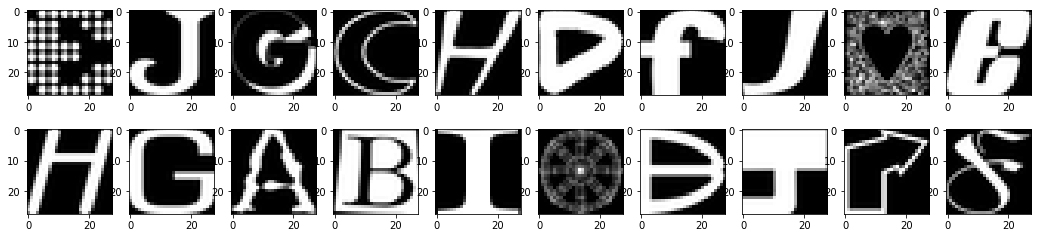

In [4]:
import math

# display the dataset and labels
img_idx_list = list(range(0,20))
img_idx_len = len(img_idx_list)

col_num = 10
row_num = math.ceil(img_idx_len / col_num)

print("%d, %d" % (row_num, col_num))

plt.figure(figsize=(18, 2 * row_num))
for i, idx in enumerate(img_idx_list):
    print(label_dic[train_labels_rw[idx]], end=' ')
    if i % col_num + 1 == col_num:
        print()
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(train_dataset_rw[idx], cmap='gray')

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
train_dataset = {}
valid_dataset = {}
test_dataset = {}

image_size = 28
num_labels = 10
layers_info_text = ''


def reformat(dataset, labels, name):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)

    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    print(name, 'dataset shape :', dataset.shape, labels.shape)
    return dataset, labels


train_dataset["Input_X"], train_dataset["Labels"] = reformat(train_dataset_rw, train_labels_rw, 'train')
valid_dataset["Input_X"], valid_dataset["Labels"] = reformat(valid_dataset_rw, valid_labels_rw, 'valid')
test_dataset["Input_X"], test_dataset["Labels"] = reformat(test_dataset_rw, test_labels_rw, 'test')


train dataset shape : (200000, 784) (200000, 10)
valid dataset shape : (10000, 784) (10000, 10)
test dataset shape : (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


def show_result(predictions, labels):
    print([label_dic[key] for key in np.argmax(predictions, 1)])
    print([label_dic[key] for key in np.argmax(labels, 1)])



In [7]:
# Define a fully connected layer
def fc_layer(input_data, channels_in, channels_out, act=None, dropout_kp=None,
             layer_name='Full_Connection_Layer', logs=None):
    with tf.name_scope(layer_name):
        # It is not a good idea to set initial value as zero
        # It will cause problem during the learning activity
        # w = tf.Variable(tf.zeros([channels_in, channels_out]))

        # These are the parameters that we are going to be training. The weight
        # matrix will be initialized using random values following a (truncated)
        # normal distribution.

        with tf.variable_scope(layer_name):
            # weights = tf.Variable(tf.truncated_normal([channels_in, channels_out], seed=1), name='W')
            weights = tf.get_variable(name='Weights', shape=[channels_in, channels_out], \
                                      initializer=tf.truncated_normal_initializer())
            # The biases get initialized to zero.
            # biases = tf.Variable(tf.zeros([channels_out]), name='B')
            biases = tf.get_variable(name='Biases', shape=[channels_out], \
                                     initializer=tf.zeros_initializer())
            if logs == 'Y':
                tf.summary.histogram("Weights", weights)
                tf.summary.histogram("Biases", biases)

        fc_conn = tf.matmul(input_data, weights)

        if act == 'relu':
            act = tf.nn.relu(fc_conn + biases, name='Relu')
        else:
            act = fc_conn + biases

        if (dropout_kp > 0) and (dropout_kp < 1):
            act = tf.nn.dropout(act, keep_prob=dropout_kp, name='Dropout_Act')

        result = act

        return result
    

In [8]:
# Define a Convolutional layer
def conv_layer(input_x, channels_in, channels_out, layer_name='Convolutional_Layer'):
    with tf.name_scope(layer_name):
        with tf.variable_scope(layer_name):
            weights = tf.Variable(tf.zeros([5, 5, channels_in, channels_out]), name='Weights')
            biases = tf.Variable(tf.zeros(channels_out), name='Biases')
        conv_conn = tf.nn.conv2d(input_x, weights, strides=[1, 1, 1, 1], padding='SAME')
        act = tf.nn.relu(conv_conn + biases)

        tf.summary.histogram("Weights", weights)
        tf.summary.histogram("Biases", biases)
        # tf.summary.histogram("conv_conn", conv_conn)

        return act

In [9]:
# build the network graph
def build_neural_network_graph(input_data, label, hidden_layers, loss, train):

    global layers_info_text

    """
        Implements a multilayer neural network with different hidden sizes
        It also adds the dropout and learning rate regularization
        techniques in the computational graph.
    """
    graph = tf.Graph()

    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        with tf.name_scope('Input_X'):
            tf_train_dataset = tf.placeholder(tf.float32, shape=(None, input_data['node_size']), name=input_data['name'])
        # label data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        with tf.name_scope('Labels_y'):
            tf_train_labels = tf.placeholder(tf.float32, shape=(None, label['node_size']), name=label['name'])

        tf_beta_l2_regu = tf.constant(loss['beta_l2_regu'], name='beta_l2_regu')

        with tf.name_scope('To_Image'):
            # Reshape to Image size
            tf_train_ds_image = tf.reshape(tf_train_dataset, [-1, 28, 28, 1])
            # tensorboard logging
            tf.summary.image('input', tf_train_ds_image, 3)

        # Model
        prev_size = input_data['node_size']
        data_layer = tf_train_dataset
        layers_info_text = "%d_Layers" % (len(hidden_layers) + 1)

        for index, layer in enumerate(hidden_layers):
            print("Build layer:", layer['name'])
            if layer['layer_type'] == 'FC':
                data_layer = fc_layer(data_layer, prev_size, layer['node_size'],
                                      layer_name=layer['name'], act=layer['act'],
                                      dropout_kp=layer['dropout_kp'], logs=layer['logs'])
            elif layer['layer_type'] == 'CNN':
                print("CNN not defined yet")
                # TODO complete later
            else:
                print("Error: Unknown Type [%s] of Layer No %d" % (layer['type'], index))

            prev_size = layer['node_size']

        logits = data_layer

        # Loss
        with tf.name_scope('loss_function'):
            l2_loss = 0
            prev_size = input_data['node_size']
            for index, layer in enumerate(hidden_layers):
                if layer['L2_regularization'] == 'Y':
                    with tf.variable_scope(layer['name'], reuse=True):
                        weights_for_l2_regu = tf.get_variable("Weights", [prev_size, layer['node_size']])
                    l2_loss += tf.nn.l2_loss(weights_for_l2_regu)
                prev_size = layer['node_size']

            softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits,
                                                                               name='cross_entropy')

            loss = tf.add(tf.reduce_mean(softmax_cross_entropy, name='loss'), tf_beta_l2_regu * l2_loss,
                          name='total_loss')

            tf.summary.scalar('total_loss', loss)
            # tf.summary.scalar('beta_l2_regu', tf_beta_l2_regu)
            tf.summary.scalar('l2_loss', l2_loss)

        # Optimizer.
        with tf.name_scope('Optimizer'):
            global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
            learning_rate = tf.train.exponential_decay(train['learning_rate'],
                                                       global_step,
                                                       train['learning_rate_decay_step'],
                                                       train['learning_rate_decay_rate'],staircase=True)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
            # tf.summary.scalar('global_step', global_step)
            tf.summary.scalar('learning_rate', learning_rate)

        # Accuracy
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_train_labels, 1))
            accuracy_res = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.summary.scalar('Accuracy_Result', accuracy_res)

        info = {
            "GRAPH": graph,
            "TF_TRAIN_DATASET": tf_train_dataset,
            "TF_TRAIN_LABELS": tf_train_labels,
            "LOSS": loss,
            # Optimizer.
            "OPTIMIZER": optimizer,
            # Predictions for the training, validation, and test data.
            "PREDICTION": tf.nn.softmax(logits),
            # "VALID": tf.nn.softmax(valid_logits),
            # "TEST": tf.nn.softmax(test_logits)
        }
    return info


In [10]:

def train_model(model_info, train_dataset, valid_dataset, test_dataset, batch_size, train_steps, log_steps):
    """
        Initializes and runs the tensor's graph
    """
    with tf.Session(graph=model_info['GRAPH']) as session:

        # Initialize all the variables
        # session.run(tf.global_variables_initializer())
        tf.global_variables_initializer().run()
        print("Initialized")

        # Make the tensorboard log writer
        session_log_dir = "logs/3_4/" + layers_info_text + "/" + dt.today().strftime('%m%d_%H%M')
        writer = tf.summary.FileWriter(session_log_dir)
        print("Logging Directory : %s" % session_log_dir)

        writer.add_graph(session.graph)

        # Merge all the tf summary
        merged_summary = tf.summary.merge_all()

        # Data Set
        # Minibatch will be built in loop

        tf_train_dataset = model_info['TF_TRAIN_DATASET']
        tf_train_labels = model_info['TF_TRAIN_LABELS']

        valid_feed_dict = {tf_train_dataset: valid_dataset["Input_X"], tf_train_labels: valid_dataset["Labels"]}

        test_feed_dict = {tf_train_dataset: test_dataset["Input_X"], tf_train_labels: test_dataset["Labels"]}

        for step in range(train_steps):

            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_dataset["Input_X"].shape[0] - batch_size)

            # focus on the 5 data batch to get overfitting case.
            # offset = batch_size * (step % 5)

            # Generate a minibatch.
            batch_data = train_dataset["Input_X"][offset:(offset + batch_size), :]
            batch_labels = train_dataset["Labels"][offset:(offset + batch_size), :]

            # print("batch_data shape :", batch_data.shape)
            # print("batch_labels shape : ", batch_labels.shape)

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.

            train_feed_dict = {tf_train_dataset: batch_data,
                               tf_train_labels: batch_labels,
                               }

            if step % log_steps == 0:
                s = session.run(merged_summary, feed_dict=train_feed_dict)
                writer.add_summary(s, step)

            targets = [model_info["OPTIMIZER"], model_info["LOSS"], model_info["PREDICTION"]]
            _, l, train_prediction = session.run(targets, feed_dict=train_feed_dict)

            if step % 500 == 0:
                # Predictions for the validation, and test data.
                valid_prediction = session.run(model_info["PREDICTION"], feed_dict=valid_feed_dict)
                print("Minibatch loss at step %d: %f" % (step, l))
                # print(show_result(train_prediction, batch_labels))
                print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction, valid_dataset["Labels"]))

        test_prediction = session.run(model_info["PREDICTION"], feed_dict=test_feed_dict)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction, test_dataset["Labels"]))

        writer.close()
        session.close()


# Case 1 

1 Hidden Layer with 1024 node
Full connection for all

|Hidden1       |Batch Size  |Learning Rate  | Decay Step    | Decay Rate    | Train Steps   | T Accu (Smh)  |   Test Acc    |
|--------------|------------|---------------|---------------|---------------|---------------|---------------|---------------|
|1028          |128| 0.5           | 500           | 0.9           | 3001          |87.5% (87.4)   |   92.5%       |
|1028          |128| 0.5           | 500           | 0.9           | 6001          |86.7% (90.1)   |   93.9%       |
|1028          |128| 0.5           | 500           | 0.9           | 9001          |86.7% (91.6)   |   94.6%       |
|1028          |128| 0.5           | 500           | 0.9           | 12001         |91.4% (92.6)   |   94.9%       |
|1028          |512| 0.5           | 500           | 0.9           | 15001         |95.3% (95.5)   |   95.3%       |


## Test with different decay step 
### slow the reduce speed to get high learning rate

* reduce the Learning Rate to be good for the learning (Smooth Accuracy)
* Batch Size : 128

|Hidden1       |Learning Rate  | Decay Step    | Decay Rate    | Train Steps   | T Accu (Smh)  |   Test Acc    |
|--------------|---------------|---------------|---------------|---------------|---------------|---------------|
|1028          | 0.5           | 500           | 0.9           | 9001          |86.7% (91.6)   |   94.6%       |
|1028          | 0.5           | 1000          | 0.9           | 9001          |91.4% (90.8)   |   94.7%       |
|1028          | 0.5           | 2000          | 0.9           | 9001          |87.5% (90.0)   |   94.7%       |


## Test with different Batch Size

|Hidden1  |Batch Size  |Learning Rate  | Decay Step    | Decay Rate    | Train Steps   | T Accu (Smh)  |   Test Acc    |
|---------|------------|---------------|---------------|---------------|---------------|---------------|---------------|
|1028     |128| 0.5           | 500           | 0.9           | 9001          |86.7% (91.6)   |   94.6%       |
|1028     |256| 0.5           | 500           | 0.9           | 9001          |92.2% (92.2)   |   94.8%       |
|1028     |512| 0.5           | 500           | 0.9           | 9001          |94.9% (95.0)   |   94.9%       |


## 1 Hidden Layer with different node
1000 node is the perfect number


|Hidden1       |Batch Size  |Learning Rate  | Decay Step    | Decay Rate    | Train Steps   | T Accu (Smh)  |   Test Acc    |
|--------------|------------|---------------|---------------|---------------|---------------|---------------|---------------|
|256           |128| 0.5           | 500           | 0.9           | 3001          |84.5% (85.5)   |   91.4%       |
|500           |128| 0.5           | 500           | 0.9           | 3001          |86.5% (86.4)   |   92.4%       |
|1028          |128| 0.5           | 500           | 0.9           | 3001          |87.5% (87.4)   |   92.5%       |
|2000          |128| 0.5           | 500           | 0.9           | 3001          |87.5% (87.9)   |   92.4%       |


In [22]:
input_x = {
    'name': 'input',
    'layer_type': 'input',
    'node_size': image_size * image_size
}

label_y = {
    'name': 'label',
    'layer_type': 'label',
    'node_size': num_labels
}

# build the deep learning network
hidden_1 = {
    'name': 'FC_hidden_1',
    'layer_type': 'FC',
    'node_size': 250,
    'act': 'relu',
    'dropout_kp': 1,
    'L2_regularization': 'Y',
    'logs': 'Y'
}

output_y = {
    'name': 'FC_conn_output',
    'layer_type': 'FC',
    'node_size': num_labels,
    'act': None,
    'dropout_kp': 1,
    'L2_regularization': 'N',
    'logs': 'N'
}

layer_design = [
    hidden_1,
    output_y
]

loss_params = {
    'beta_l2_regu': 0.001
}

train_params = {
    'learning_rate': 0.5,
    'learning_rate_decay_step': 500,
    'learning_rate_decay_rate': 0.9
}

model_information = build_neural_network_graph(input_data=input_x, label=output_y, hidden_layers=layer_design,
                                               loss=loss_params, train=train_params)

# run the deep learning network
batch_size = 128
num_steps = 3001
log_steps = 5

train_model(model_info=model_information, train_dataset=train_dataset, valid_dataset=valid_dataset,
            test_dataset=test_dataset, batch_size=batch_size, train_steps=num_steps, log_steps=log_steps)

Build layer: FC_hidden_1
Build layer: FC_conn_output
Initialized
Logging Directory : logs/3_4/3_Layers/1008_1603
Minibatch loss at step 0: 230.559891
Minibatch accuracy: 9.4%
Validation accuracy: 27.4%
Minibatch loss at step 500: 48.355904
Minibatch accuracy: 74.2%
Validation accuracy: 73.5%
Minibatch loss at step 1000: 29.586899
Minibatch accuracy: 79.7%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 19.466707
Minibatch accuracy: 87.5%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 13.460576
Minibatch accuracy: 86.7%
Validation accuracy: 84.0%
Minibatch loss at step 2500: 9.927414
Minibatch accuracy: 85.9%
Validation accuracy: 84.4%
Minibatch loss at step 3000: 7.508732
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Test accuracy: 91.6%


# Case 2


In [ ]:
input_x = {
    'name': 'input',
    'layer_type': 'input',
    'node_size': image_size * image_size
}

label_y = {
    'name': 'label',
    'layer_type': 'label',
    'node_size': num_labels
}

# build the deep learning network
hidden_1 = {
    'name': 'FC_hidden_1',
    'layer_type': 'FC',
    'node_size': 256,
    'act': 'relu',
    'dropout_kp': 1,
    'L2_regularization': 'Y',
    'logs': 'Y'
}

hidden_2 = {
    'name': 'FC_hidden_2',
    'layer_type': 'FC',
    'node_size': 1024,
    'act': 'relu',
    'dropout_kp': 1,
    'L2_regularization': 'N',
    'logs': 'Y'
}

hidden_3 = {
    'name': 'FC_hidden_3',
    'layer_type': 'FC',
    'node_size': 512,
    'act': None,
    'dropout_kp': 1,
    'L2_regularization': 'N',
    'logs': 'Y'
}

output_y = {
    'name': 'FC_conn_output',
    'layer_type': 'FC',
    'node_size': num_labels,
    'act': None,
    'dropout_kp': 1,
    'L2_regularization': 'N',
    'logs': 'N'
}

layer_design = [
    # hidden_1,
    hidden_2,
    hidden_3,
    output_y
]

loss_params = {
    'beta_l2_regu': 0.001
}

train_params = {
    'learning_rate': 0.01,
    'learning_rate_decay_step': 500,
    'learning_rate_decay_rate': 0.9
}

model_information = build_neural_network_graph(input_data=input_x, label=output_y, hidden_layers=layer_design,
                                               loss=loss_params, train=train_params)

# run the deep learning network
batch_size = 128
num_steps = 3001
log_steps = 10

train_model(model_info=model_information, train_dataset=train_dataset, valid_dataset=valid_dataset,
            test_dataset=test_dataset, batch_size=batch_size, train_steps=num_steps, log_steps=log_steps)